# Air-Quality Satellite Temporal Signals 


Here I collected in a dataframe calculated statistics related to  different air quality temporal signals from the following products:

    
    OMAEROG
    https://disc.gsfc.nasa.gov/datasets/OMAEROG_003/summary?keywords=AIR%20QUALITY
    
    OMSO2e
    https://disc.gsfc.nasa.gov/datasets/OMSO2e_003/summary?keywords=ColumnAmountSO2_PBL
    
    OMANO2
    https://disc.gsfc.nasa.gov/datasets/OMNO2G_003/summary?keywords=ColumnAmountNO2
    


### Output
    NASA_airquality.csv

### Schema datasets

#  Library 

In [1]:
import numpy as np 
import h5py 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

from os import listdir
from os.path import isfile, join
import os 


In [7]:
location_range_italy = {"llcrnrlat":30, "urcrnrlat" : 50, "llcrnrlon":4, "urcrnrlon" : 20}
location_range_all = {"llcrnrlat":-90, "urcrnrlat" : 90, "llcrnrlon":-180, "urcrnrlon" : 180}


# this get all file froma a directory 
def get_files(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and not f.startswith(".")]
    return sorted(onlyfiles)


def get_stats(data_info, signal, datafiles, index=None, stat=np.mean):
    #FILE_NAME = ppp
    #DATAFIELD_NAME = '/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields/SlantColumnAmountSO2'
    #loc = location_range_italy
    #fig = plt.figure(figsize=[15,15])

    DATAFIELD_NAME = data_info['datafield']+ "/" +signal["name"]
    out =[]
    for d in datafiles:
        FILE_NAME = os.path.join(data_info['path'], d)
        with h5py.File(FILE_NAME, mode='r') as f:
            # List available datasets.
            #print(f.keys())

            # Read dataset.
            dset = f[DATAFIELD_NAME]
            data = dset[:]
            #denom = np.meadian(data) 
            
            shape = data.shape
            
            
            if index is None:
                out.append(stat(data))
            else:
                out.append(stat(data[index]))
            
    return out



def show_map(FILE_NAME, DATAFIELD_NAME, loc):
# Open file.

    fig = plt.figure(figsize=[15,15])
    with h5py.File(FILE_NAME, mode='r') as f:
        # List available datasets.
        print(f.keys())

        # Read dataset.
        dset = f[DATAFIELD_NAME]
        data = dset[:]

        data = data[data!=-1.2676506E30]
        # Handle fill value.
        #data[data == dset.fillvalue] = np.nan
        #data = np.ma.masked_where(np.isnan(data), data)

        # Get attributes needed for the plot.
        # String attributes actually come in as the bytes type and should
        # be decoded to UTF-8 (python3).
        title = dset.attrs['Title'].decode()
        units = dset.attrs['Units'].decode()

        longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
        latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125

        #m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat = 90, llcrnrlon=-180, urcrnrlon = 180)
        m = Basemap(projection='cyl', 
                    resolution='l', 
                    llcrnrlat=loc["llcrnrlat"], 
                    urcrnrlat = loc["urcrnrlat"], 
                    llcrnrlon=loc["llcrnrlon"], 
                    urcrnrlon = loc["urcrnrlon"])

        m.drawcoastlines(linewidth=3)
        m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])
        #x, y = m(longitude, latitude,)


        aaa = m.pcolormesh(longitude, latitude, data, latlon=True)
        cb = m.colorbar()
        cb.set_label(units)
        
# extract froom filename the timestamp
def get_timestamp(file_name):
    date = file_name[file_name.rfind('-')+1:file_name.rfind('.')]
    YYYY = date[0:date.rfind('m')]
    MM = date[date.rfind('m')+1:date.rfind('t')][0:2]
    DD = date[date.rfind('m')+1:date.rfind('t')][2:4]
    hh = date[date.rfind('t')+1:][0:2]
    mm = date[date.rfind('t')+1:][2:4]
    ss = date[date.rfind('t')+1:][4:6]
    return YYYY,MM,DD,hh,mm, ss


def xy(angle_lat, angle_lon):
    y = (-1)* 720 * angle_lon/ (-180)
    x = (-1) * 1440 * angle_lat/ (-360)
    
    if y >720: y=720
    if x >1440: x=1440

    return np.int16(np.round(x)), np.int16(np.round(y))


class storage():

    def __init__(self):

        #self.location = location
       
        #self.filename = filename
        #self.schema ={'date': '', 
        #              'hashtag': '', 
        #              'username': ''}
        
        self.schema = {'product_shortname': '', \
                       "signal_name":'',\
                       'value': '',\
                      'year': '',\
                      'month': '',\
                      'day': '', \
                      'hour': '', \
                      'minutes': '', \
                      'seconds':'', \
                      }
    
        self.df = None

        #self.load()

        if self.df is None: self.new()

    def new(self): 
        self.df = pd.DataFrame(columns=self.schema.keys())
        return self.df

    def load(self, location, filename, verbose=False):

        spath = location + '/' + filename

        if not os.path.isfile(spath):
            if verbose:
                print('Error: file not found:', spath)
            return -1

        self.df = pd.read_csv(spath, index_col=False)
        return 0

    def show(self): self.df.head()

    def schema(self): return schema

    def add(self, rowdic):
        try:
            #print(rowdic)
            self.df = self.df.append(rowdic, ignore_index=True)
            # return self.df

        except Exception() as e:
            print('Error:', e, '\n Schema:', self.schema)
            # return None

    def save(self, location, filename):
        spath = location

        if not os.path.exists(spath):
            os.makedirs(spath)

        spath = spath + '/' + filename
       
        if not os.path.isfile(spath):
            self.df.to_csv(spath, header=self.schema.keys(), index=False, columns=self.schema)
        else:  # else it exists so append without writing the header
            self.df.to_csv(spath, mode='w', header=True, index=False, columns=self.schema)
  
    def concat(self, storage2):
        self.df = pd.concat([self.df, storage2.df], ignore_index=True)



def create_dataframe(data_info, signal, locations, units="DU", stat = np.mean, minv = None, maxv=None):
    #FILE_NAME = ppp
    #DATAFIELD_NAME = '/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields/SlantColumnAmountSO2'
    #loc = location_range_italy
    #fig = plt.figure(figsize=[15,15])
    st = storage()
    
    datafiles = get_files(data_info['path'])
    
    DATAFIELD_NAME = data_info['datafield']+ "/" +signal["name"]
    out =[]
    for d in datafiles:
        
        
        FILE_NAME = os.path.join(data_info['path'], d)
        with h5py.File(FILE_NAME, mode='r') as f:
            # List available datasets.
            #print(f.keys())

            # Read dataset.
            dset = f[DATAFIELD_NAME]
            data = dset[:]
            
                
            if units =="DU":
                DU = 2.6867*10**16
                data_filtered = data_filtered/DU 

            if minv is not None:
                data_filtered[data_filtered<minv]=np.NaN
            if maxv is not None:
                data_filtered[data_filtered>maxv]=np.NaN

            # extract time from the file name
            YYYY,MM,DD,hh,mm, ss = get_timestamp(d)
            
            for location in locations:
                
                stats = get_location_stats(location, data_filtered, 
                       units="DU" , minv=minv, maxv=maxv, min_percdata_forstats=0.9)
                
                mn = stats[0]
                sd = stats[1]
                md = stats[2]
                q1 = stats[3]
                q2 = stats[4]
                
                row = {'product_shortname': data_info['shortname'],
                   "signal_name": signal["name"],
                   'value_mn': stats[0],
                    'value_sd': stats[1],
                    'value_md': stats[2],
                    'value_q1': stats[3],
                    'value_q2': stats[4],
                    'loc_name': location["name"],
                   'loc_lat': location["lat"],
                   'loc_lang': location["long"],
                   'loc_zoom': location["zoom"],
                   'year': YYYY,
                    'month': MM,
                    'day': DD, 
                    'hour': hh, 
                    'minutes': mm, 
                    'seconds':ss
                    }
                
                st.add(row)
            
            
            '''
            shape = data.shape
            if len(shape)==4: #nwave
                for i in range(signal["nwave"]):
                    data_nwave = data[:,i,:,:]
                    data_nwave = data_nwave.reshape([data_nwave.shape[0]*data_nwave.shape[1]*data_nwave.shape[2]])
                    stat_val = stat(data_nwave[data_nwave!=signal['missing_value']])
                    row['signal_name']= signal["name"]+"_nwave_" +str(i)
                    row['value']= stat_val
                    st.add(row)
                    
            if len(shape)==3:
                data = data.reshape([data.shape[0]*data.shape[1]*data.shape[2]])
                stat_val = stat(data[data!=signal['missing_value']])
                row['value']= stat_val
                st.add(row)
                
            if len(shape)==2:
                data = data.reshape([data.shape[0]*data.shape[1]])
                stat_val = stat(data[data!=signal['missing_value']])
                row['value']= stat_val
                st.add(row)
            '''
    return st


def get_location_stats(location, data, zoom = 1, \
                       units="DU" , minv=None, maxv=None, min_percdata_forstats=0.9, \
                       show_map=False, show_stats=False, \
                       figsize = [7,7]):
    '''
    location = info about location, ex. format = {"lat":39, "long" :116, "zoom":5}
    data = 2d array (lat x long) of satellite signals
    units = DU of molcm2, 1 DU = 2.6867*10**16 mol/cm2
    min_percdata_forstats= is the minumu perc of data to produce statistic. satellites can have dark zones
    
    '''
    longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
    latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125

    X = np.argwhere((latitude>location["lat"]-zoom) & (latitude<=location["lat"]+zoom)).flatten()
    Y = np.argwhere((longitude>location["long"]-zoom) & (longitude<=location["long"]+zoom)).flatten()
    data_filtered = data[X,:]
    data_filtered = data_filtered[:,Y]
    
    if units =="DU":
        DU = 2.6867*10**16
        data_filtered = data_filtered/DU 
        
    if minv is not None:
        data_filtered[data_filtered<minv]=np.NaN
    if maxv is not None:
        data_filtered[data_filtered>maxv]=np.NaN

    if show_map ==True:
        plt.figure(figsize=figsize)
        plt.imshow(data_filtered, cmap="Paired", vmin=minv, vmax=maxv)
        plt.show()
    if show_stats == True:
        d = [ i for i in data_filtered.flatten()  if i >0 ]
        bp = sns.boxplot(d)
        sns.stripplot(d, color="orange", jitter=0.2, size=2.5,)

        #plt.show()
    
    # if num nan is > then 90% return Nan (it means that the satellite was not covering the area)
    num_nan = data_filtered[np.isnan(data_filtered)].shape[0]
    n = data_filtered.flatten().shape[0]
    if (num_nan/n)>=min_percdata_forstats:
        return np.Nan,np.Nan,np.Nan,np.Nan,np.Nan
    
    Q1 = np.nanpercentile(data_filtered, 25)
    MD = np.nanpercentile(data_filtered, 50)
    Q2 = np.nanpercentile(data_filtered, 75)
    SD = np.nanstd(data_filtered)
    MN = np.nanmean(data_filtered)
    
    return MN, SD, MD, Q1, Q2


def get_missing_Value(datadescr, signal):
    
    datafiles = get_files(datadescr['path'])
    f0 = h5py.File(os.path.join(datadescr['path'], datafiles[0]),"r")

    dd= f0[datadescr['datafield']+"/"+signal['name']]
    dd = np.array(dd)
    n = len(dd.shape)
    if n==4:
        ddd = dd.reshape([dd.shape[0]*dd.shape[1]*dd.shape[2]*dd.shape[3]])
    if n==3:
        ddd = dd.reshape([dd.shape[0]*dd.shape[1]*dd.shape[2]])
    if n==2:
        ddd = dd.reshape([dd.shape[0]*dd.shape[1]])
    
    return np.min(ddd)


# OMAEROG dataframe

data feilds:

<KeysViewHDF5 ['AerosolModelMW', 'AerosolModelsPassedThreshold', 'AerosolOpticalThicknessMW', 'AerosolOpticalThicknessMWPrecision', 'AerosolOpticalThicknessPassedThresholdMean', 'AerosolOpticalThicknessPassedThresholdStd', 'CloudFlags', 'CloudPressure', 'EffectiveCloudFraction', 'GroundPixelQualityFlags', 'InstrumentConfigurationId', 'Latitude', 'LineNumber', 'Longitude', 'MeasurementQualityFlags', 'NumberOfCandidateScenes', 'NumberOfModelsPassedThreshold', 'OrbitNumber', 'PathLength', 'ProcessingQualityFlagsMW', 'RootMeanSquareErrorOfFitPassedThreshold', 'SceneNumber', 'SingleScatteringAlbedoMW', 'SingleScatteringAlbedoMWPrecision', 'SingleScatteringAlbedoPassedThresholdMean', 'SingleScatteringAlbedoPassedThresholdStd', 'SolarAzimuthAngle', 'SolarZenithAngle', 'SpacecraftAltitude', 'SpacecraftLatitude', 'SpacecraftLongitude', 'TerrainHeight', 'TerrainPressure', 'TerrainReflectivity', 'Time', 'UVAerosolIndex', 'VISAerosolIndex', 'ViewingAzimuthAngle', 'ViewingZenithAngle', 'XTrackQualityFlags']>

documentation

https://disc.gsfc.nasa.gov/datasets/OMAEROG_003/summary?keywords=AIR%20QUALITY

https://acdisc.gesdisc.eosdis.nasa.gov/data/Aura_OMI_Level2G/OMAEROG.003/doc/OMAEROG_OSIPS_README_V003.doc

Data

https://acdisc.gsfc.nasa.gov/data/Aura_OMI_Level2G/


In [27]:
datadesc_OMAEROG = {"shortname":"OMAEROG",
                    "path":"./OMAEROG", 
                    "datafield":"/HDFEOS/GRIDS/ColumnAmountAerosol/Data Fields"}

In [28]:
signal_SingleScatteringAlbedoMW = {"name":"SingleScatteringAlbedoMW", 
                         "missing_value":-32767, 
                         "nCandidate":15, 
                         "nwave":5}

signal_SingleScatteringAlbedoPassedThresholdMean = {"name":"SingleScatteringAlbedoPassedThresholdMean", 
                         "missing_value":-32767, 
                         "nCandidate":15,
                        "nwave":5  }

signal_AerosolModelMW = {"name":"AerosolModelMW", 
                         "missing_value":65535, 
                         "nCandidate":15}


signal_AerosolOpticalThicknessMWPrecision = {"name":"AerosolOpticalThicknessMWPrecision", 
                         "missing_value":-32767, 
                         "nCandidate":15}


signal_CloudPressure = {"name":"CloudPressure", 
                         "missing_value":-1.2676506e+30, 
                         "nCandidate":15}


signal_TerrainReflectivity = {"name":"TerrainReflectivity", 
                         "missing_value":-32767, 
                         "nCandidate":15,
                         "nwave":5  }

In [9]:

st1 = create_dataframe(datadesc_OMAEROG, signal_SingleScatteringAlbedoMW)
st1.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMAEROG,SingleScatteringAlbedoMW_nwave_0,956.601491,2020,01,02,06,20,17
1,OMAEROG,SingleScatteringAlbedoMW_nwave_1,960.400810,2020,01,02,06,20,17
2,OMAEROG,SingleScatteringAlbedoMW_nwave_2,964.367310,2020,01,02,06,20,17


In [10]:
st2 = create_dataframe(datadesc_OMAEROG, signal_SingleScatteringAlbedoPassedThresholdMean)
st2.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMAEROG,SingleScatteringAlbedoPassedThresholdMean_nwave_0,951.622887,2020,01,02,06,20,17
1,OMAEROG,SingleScatteringAlbedoPassedThresholdMean_nwave_1,955.351970,2020,01,02,06,20,17
2,OMAEROG,SingleScatteringAlbedoPassedThresholdMean_nwave_2,958.541929,2020,01,02,06,20,17


In [11]:
st3 = create_dataframe(datadesc_OMAEROG, signal_AerosolModelMW)
st3.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMAEROG,AerosolModelMW,1444.763949,2020,01,02,06,20,17
1,OMAEROG,AerosolModelMW,1462.383359,2020,01,20,06,25,30
2,OMAEROG,AerosolModelMW,1462.383359,2020,01,20,06,25,30


In [12]:
st4 = create_dataframe(datadesc_OMAEROG, signal_AerosolOpticalThicknessMWPrecision)
st4.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMAEROG,AerosolOpticalThicknessMWPrecision,76.684764,2020,01,02,06,20,17
1,OMAEROG,AerosolOpticalThicknessMWPrecision,62.510593,2020,01,20,06,25,30
2,OMAEROG,AerosolOpticalThicknessMWPrecision,62.510593,2020,01,20,06,25,30


In [13]:
st5 = create_dataframe(datadesc_OMAEROG, signal_CloudPressure)
st5.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMAEROG,CloudPressure,554.797913,2020,01,02,06,20,17
1,OMAEROG,CloudPressure,564.631653,2020,01,20,06,25,30
2,OMAEROG,CloudPressure,564.631653,2020,01,20,06,25,30


In [14]:
st6 = create_dataframe(datadesc_OMAEROG, signal_TerrainReflectivity)
st6.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMAEROG,TerrainReflectivity_nwave_0,298.153878,2020,01,02,06,20,17
1,OMAEROG,TerrainReflectivity_nwave_1,302.323957,2020,01,02,06,20,17
2,OMAEROG,TerrainReflectivity_nwave_2,294.929467,2020,01,02,06,20,17



# OMANO2 dataframe

data feilds:

<KeysViewHDF5 ['ColumnAmountNO2', 'ColumnAmountNO2CloudScreened', 'ColumnAmountNO2Trop', 'ColumnAmountNO2TropCloudScreened', 'Weight']>

documentation

https://disc.gsfc.nasa.gov/datasets/OMNO2G_003/summary?keywords=ColumnAmountNO2

https://acdisc.gesdisc.eosdis.nasa.gov/data/Aura_OMI_Level2G/OMAEROG.003/doc/OMAEROG_OSIPS_README_V003.doc

Data

https://acdisc.gsfc.nasa.gov/data/Aura_OMI_Level2G/


    group: Data_Fields {
    variables:
      float ColumnAmountNO2(YDim=720, XDim=1440);
        :_FillValue = -1.2676506E30f; // float
        :MissingValue = -1.2676506E30f; // float
        :ScaleFactor = 1.0f; // float
        :Offset = 0.0f; // float
        :Units = "molec/cm2";
        :Title = "NO2 vertical column density";
        :Description = "Field=ColumnAmountNO2,StdField=ColumnAmountNO2Std,SolarZenithAngle=[0:85],VcdQualityFlags=~19,XTrackQualityFlags=~[1:254],TerrainReflectivity=[0:1000]";
        :_ChunkSizes = 720U, 1440U; // uint
        :units = "molec/cm2";

      float ColumnAmountNO2CloudScreened(YDim=720, XDim=1440);
        :_FillValue = -1.2676506E30f; // float
        :MissingValue = -1.2676506E30f; // float
        :ScaleFactor = 1.0f; // float
        :Offset = 0.0f; // float
        :Units = "molec/cm2";
        :Title = "NO2 vertical column density, screened for CloudFraction < 30%";
        :Description = "Field=ColumnAmountNO2,StdField=ColumnAmountNO2Std,SolarZenithAngle=[0:85],CloudFraction=[0:300],VcdQualityFlags=~19,XTrackQualityFlags=~[1:254],TerrainReflectivity=[0:1000]";
        :_ChunkSizes = 720U, 1440U; // uint
        :units = "molec/cm2";

      float ColumnAmountNO2Trop(YDim=720, XDim=1440);
        :_FillValue = -1.2676506E30f; // float
        :MissingValue = -1.2676506E30f; // float
        :ScaleFactor = 1.0f; // float
        :Offset = 0.0f; // float
        :Units = "molec/cm2";
        :Title = "NO2 tropospheric column density";
        :Description = "Field=ColumnAmountNO2Trop,StdField=ColumnAmountNO2TropStd,SolarZenithAngle=[0:85],VcdQualityFlags=~19,XTrackQualityFlags=~[1:254],TerrainReflectivity=[0:1000]";
        :_ChunkSizes = 720U, 1440U; // uint
        :units = "molec/cm2";

      float ColumnAmountNO2TropCloudScreened(YDim=720, XDim=1440);
        :_FillValue = -1.2676506E30f; // float
        :MissingValue = -1.2676506E30f; // float
        :ScaleFactor = 1.0f; // float
        :Offset = 0.0f; // float
        :Units = "molec/cm2";
        :Title = "NO2 tropospheric column density, screened for CloudFraction < 30%";
        :Description = "Field=ColumnAmountNO2Trop,StdField=ColumnAmountNO2TropStd,SolarZenithAngle=[0:85],CloudFraction=[0:300],VcdQualityFlags=~19,XTrackQualityFlags=~[1:254],TerrainReflectivity=[0:1000]";
        :_ChunkSizes = 720U, 1440U; // uint
        :units = "molec/cm2";

      float Weight(YDim=720, XDim=1440);
        :Units = "NoUnits";
        :_FillValue = -1.2676506E30f; // float
        :MissingValue = -1.2676506E30f; // float
        :ScaleFactor = 1.0f; // float
        :Offset = 0.0f; // float
        :Title = "Weight Factor used for each Grid Cell";
        :Description = "";
        :_ChunkSizes = 720U, 1440U; // uint
        :units = "NoUnits";



In [53]:
# extract froom filename the timestamp
def get_timestamp_OMANO2(file_name):
    p0 = file_name.find("OMNO2d_")+len("OMNO2d_")
    p1 = file_name.find("_", p0+len("OMNO2d_"))
    date = file_name[p0:p1]
    YYYY = date[0:date.rfind('m')]
    MM = date[date.rfind('m')+1:date.rfind('m')+3]
    DD = date[date.rfind('m')+3:date.rfind('m')+6]
    hh = file_name[file_name.rfind('t')+1:][0:2]
    mm = file_name[file_name.rfind('t')+1:][2:4]
    ss = file_name[file_name.rfind('t')+1:][4:6]
    return YYYY,MM,DD,hh,mm, ss


get_timestamp_OMANO2(datafiles[0])

('2020', '01', '01', '17', '31', '00')

datadesc_OMANO2 = {"shortname":"OMANO2",
                    "path":"./OMANO2", 
                    "datafield":"/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields"}


signal_ColumnAmountNO2 = {"name":"ColumnAmountNO2", 
                         "missing_value":-1.2676506e+30}


st10 = create_dataframe(datadesc_OMANO2, signal_ColumnAmountNO2)
st10.df.head(3)

In [54]:
datadesc_OMNO2 = {"shortname":"OMNO2",
                    "path":"./data/OMNO2d.003/2020/", 
                    "datafield":"/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields"}

signal_ColumnAmountNO2TropCloudScreened = {"name":"ColumnAmountNO2TropCloudScreened",
                                           "missing_value":-1.2676506e+30}

In [55]:
st1 = create_dataframe(datadesc_OMNO2, 
                       signal_ColumnAmountNO2TropCloudScreened, 
                      split_timestamp=get_timestamp_OMANO2)
st1.df.head(3)



OMI-Aura_L3-OMNO2d_2020m0101_v003-2020m0330t173100.he5
OMI-Aura_L3-OMNO2d_2020m0102_v003-2020m0330t173624.he5
OMI-Aura_L3-OMNO2d_2020m0103_v003-2020m0330t173624.he5
OMI-Aura_L3-OMNO2d_2020m0104_v003-2020m0330t173631.he5
OMI-Aura_L3-OMNO2d_2020m0105_v003-2020m0330t174158.he5
OMI-Aura_L3-OMNO2d_2020m0106_v003-2020m0330t174145.he5
OMI-Aura_L3-OMNO2d_2020m0107_v003-2020m0330t174719.he5
OMI-Aura_L3-OMNO2d_2020m0108_v003-2020m0330t173618.he5
OMI-Aura_L3-OMNO2d_2020m0109_v003-2020m0330t174149.he5
OMI-Aura_L3-OMNO2d_2020m0110_v003-2020m0330t174148.he5
OMI-Aura_L3-OMNO2d_2020m0111_v003-2020m0330t174145.he5
OMI-Aura_L3-OMNO2d_2020m0112_v003-2020m0330t174734.he5
OMI-Aura_L3-OMNO2d_2020m0113_v003-2020m0330t174730.he5
OMI-Aura_L3-OMNO2d_2020m0114_v003-2020m0330t174842.he5
OMI-Aura_L3-OMNO2d_2020m0115_v003-2020m0330t174710.he5
OMI-Aura_L3-OMNO2d_2020m0116_v003-2020m0330t174157.he5
OMI-Aura_L3-OMNO2d_2020m0117_v003-2020m0330t174148.he5
OMI-Aura_L3-OMNO2d_2020m0118_v003-2020m0330t174723.he5
OMI-Aura_L

OMI-Aura_L3-OMNO2d_2020m0529_v003-2020m0530t173600.he5
OMI-Aura_L3-OMNO2d_2020m0530_v003-2020m0601t082258.he5
OMI-Aura_L3-OMNO2d_2020m0531_v003-2020m0601t173110.he5


,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMNO2,ColumnAmountNO2TropCloudScreened,2.733088e+14,2020,01,01,17,31,00
1,OMNO2,ColumnAmountNO2TropCloudScreened,3.099038e+14,2020,01,02,17,36,24
2,OMNO2,ColumnAmountNO2TropCloudScreened,3.069800e+14,2020,01,03,17,36,24


In [56]:
st1.save("./data", "OMNO2d_v2.csv")


# OMASO2 dataframe

data feilds:

<KeysViewHDF5 ['ColumnAmountO3', 'ColumnAmountSO2_PBL', 'Latitude', 'LineNumber', 'Longitude', 'OrbitNumber', 'PacificSectorAverage', 'RadiativeCloudFraction', 'RelativeAzimuthAngle', 'SceneNumber', 'SlantColumnAmountSO2', 'SolarZenithAngle', 'TerrainHeight', 'Time', 'ViewingZenithAngle']>

documentation

https://disc.gsfc.nasa.gov/datasets/OMSO2e_003/summary?keywords=ColumnAmountSO2_PBL


Data

https://acdisc.gsfc.nasa.gov/data/Aura_OMI_Level3/OMSO2e.003/


In [17]:
datadesc_OMSO2 = {"shortname":"OMSO2",
                    "path":"./OMSO2", 
                    "datafield":"/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields"}

In [18]:
signal_ColumnAmountO3 = {"name":"ColumnAmountO3", 
                         "missing_value":-1.2676506e+30}

signal_ColumnAmountSO2_PBL = {"name":"ColumnAmountSO2_PBL", 
                         "missing_value":-1.2676506e+30}

In [19]:
get_missing_Value(datadesc_OMSO2,signal_ColumnAmountSO2_PBL )

-1.2676506e+30

In [20]:

st7 = create_dataframe(datadesc_OMSO2, signal_ColumnAmountO3)
st7.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMSO2,ColumnAmountO3,283.909821,2020,01,03,02,12,23
1,OMSO2,ColumnAmountO3,282.979614,2020,01,10,02,25,36
2,OMSO2,ColumnAmountO3,280.916504,2020,01,20,03,23,13


In [21]:
st8 = create_dataframe(datadesc_OMSO2, signal_ColumnAmountSO2_PBL)
st8.df.head(3)

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMSO2,ColumnAmountSO2_PBL,0.005539,2020,01,03,02,12,23
1,OMSO2,ColumnAmountSO2_PBL,0.004630,2020,01,10,02,25,36
2,OMSO2,ColumnAmountSO2_PBL,0.015589,2020,01,20,03,23,13


In [22]:
st1.concat(st2)
st1.concat(st3)
st1.concat(st4)
st1.concat(st5)
st1.concat(st6)
st1.concat(st7)
st1.concat(st8)

In [23]:
st1.save("./", "NASA_signals.csv")

In [153]:

locrange_grad_italy = {"llcrnrlat":30, "urcrnrlat" : 50, "llcrnrlon":4, "urcrnrlon" : 20}

x0, y0= xy(locrange_grad_italy['llcrnrlat'], locrange_grad_italy['llcrnrlon'])
x1, y1= xy(locrange_grad_italy['urcrnrlat'], locrange_grad_italy['urcrnrlon'])

locrange_bbox_italy = {"x0":x0, "x1" : x1, "y0":y0, "y1" : y1}
locrange_bbox_italy



{'x0': 120, 'x1': 200, 'y0': 16, 'y1': 80}

In [152]:
get_timestamp(datafiles_OMAEROG[0])

('2020', '01', '02', '06', '20', '17')

In [448]:
datainfo_OMSO2 = {"type":"OMSO2","path":"./OMSO2", "datafield":"/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields"}
datafiles = get_files(datainfo_OMSO2['path'])

f0 = h5py.File(os.path.join(datainfo_OMSO2['path'], datafiles[0]),"r")
print(f0[datainfo_OMSO2['datafield']].keys())
dd = f0[datainfo_OMSO2['datafield']]

<KeysViewHDF5 ['ColumnAmountO3', 'ColumnAmountSO2_PBL', 'Latitude', 'LineNumber', 'Longitude', 'OrbitNumber', 'PacificSectorAverage', 'RadiativeCloudFraction', 'RelativeAzimuthAngle', 'SceneNumber', 'SlantColumnAmountSO2', 'SolarZenithAngle', 'TerrainHeight', 'Time', 'ViewingZenithAngle']>


In [451]:
f0[datainfo_OMSO2["datafield"]+"/"+signal_ColumnAmountO3["name"]]

<HDF5 dataset "ColumnAmountO3": shape (720, 1440), type "<f4">

In [161]:

r = {'type_signal': 'test1',
 'value': '',
 'year': '',
 'month': '',
 'day': '', 
 'hour': '', 
 'month': '', 
 'seconds':'',
}
st.add(r)

In [162]:
st.save()

# Test: data distribution (ex. OMAEROG)

In [40]:
p0 = datafiles[0].find("OMNO2d_")+len("OMNO2d_")
p1 = datafiles[0].find("_", p0+len("OMNO2d_"))
datafiles[0][p0:p1]

'2020m0101'

18

In [10]:
datadesc_OMNO2 = {"shortname":"OMNO2",
                    "path":"./data/OMNO2d.003/2020", 
                    "datafield":"/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/"}

signal_ColumnAmountNO2TropCloudScreened = {"name":"ColumnAmountNO2TropCloudScreened",
                                           "missing_value":-1.2676506e+30}

path = datadesc_OMNO2['path']
datafield = datadesc_OMNO2['datafield']
datafiles = get_files(path)

f0 = h5py.File(os.path.join(path, datafiles[0]),"r")
print(f0[datafield].keys())
dd = f0[datafield+"/ColumnAmountNO2TropCloudScreened"]
dd

<KeysViewHDF5 ['ColumnAmountNO2', 'ColumnAmountNO2CloudScreened', 'ColumnAmountNO2Trop', 'ColumnAmountNO2TropCloudScreened', 'Weight']>


<HDF5 dataset "ColumnAmountNO2TropCloudScreened": shape (720, 1440), type "<f4">

In [241]:
datainfo_OMAEROG = {"type":"OMAEROG","path":"./OMAEROG", "datafield":"/HDFEOS/GRIDS/ColumnAmountAerosol/Data Fields"}
datafiles_OMAEROG = get_files(datainfo_OMAEROG['path'])

f0 = h5py.File(os.path.join(datainfo_OMAEROG['path'], datafiles_OMAEROG[0]),"r")
print(f0[datainfo_OMAEROG['datafield']].keys())
dd = f0[datainfo_OMAEROG['datafield']]

<KeysViewHDF5 ['AerosolModelMW', 'AerosolModelsPassedThreshold', 'AerosolOpticalThicknessMW', 'AerosolOpticalThicknessMWPrecision', 'AerosolOpticalThicknessPassedThresholdMean', 'AerosolOpticalThicknessPassedThresholdStd', 'CloudFlags', 'CloudPressure', 'EffectiveCloudFraction', 'GroundPixelQualityFlags', 'InstrumentConfigurationId', 'Latitude', 'LineNumber', 'Longitude', 'MeasurementQualityFlags', 'NumberOfCandidateScenes', 'NumberOfModelsPassedThreshold', 'OrbitNumber', 'PathLength', 'ProcessingQualityFlagsMW', 'RootMeanSquareErrorOfFitPassedThreshold', 'SceneNumber', 'SingleScatteringAlbedoMW', 'SingleScatteringAlbedoMWPrecision', 'SingleScatteringAlbedoPassedThresholdMean', 'SingleScatteringAlbedoPassedThresholdStd', 'SolarAzimuthAngle', 'SolarZenithAngle', 'SpacecraftAltitude', 'SpacecraftLatitude', 'SpacecraftLongitude', 'TerrainHeight', 'TerrainPressure', 'TerrainReflectivity', 'Time', 'UVAerosolIndex', 'VISAerosolIndex', 'ViewingAzimuthAngle', 'ViewingZenithAngle', 'XTrackQuali

In [336]:
signal_AerosolOpticalThicknessMWPrecision = {"name":"AerosolOpticalThicknessMWPrecision", "missing_value":-32767, "nCandidate":15}
signal_AerosolOpticalThicknessMWPrecision

{'name': 'AerosolOpticalThicknessMWPrecision',
 'missing_value': -32767,
 'nCandidate': 15}

In [367]:
signal_AerosolModelsPassedThreshold = {"name":"AerosolModelsPassedThreshold", 
                                             "missing_value":-32767, 
                                             "nCandidate":15,
                                             "nwave":5}
signal_AerosolModelsPassedThreshold

{'name': 'AerosolModelsPassedThreshold',
 'missing_value': -32767,
 'nCandidate': 15}

# Remove background by removing missing values ( I treat satellite acquisitions like cellualr microscopy acquisitions)

<KeysViewHDF5 ['ColumnAmountNO2', 'ColumnAmountNO2CloudScreened', 'ColumnAmountNO2Trop', 'ColumnAmountNO2TropCloudScreened', 'Weight']>


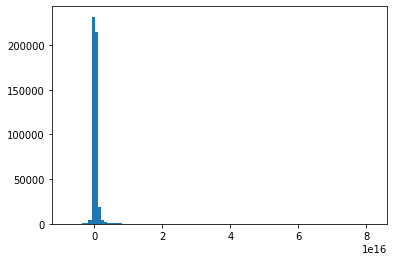

In [62]:
signal = signal_ColumnAmountNO2TropCloudScreened
datadescr = datadesc_OMNO2

path = datadescr['path']
datafield = datadescr['datafield']
datafiles = get_files(path)

f0 = h5py.File(os.path.join(path, datafiles[1]),"r")
print(f0[datafield].keys())
dd = f0[datafield+"/ColumnAmountNO2TropCloudScreened"]
dd

dd = np.array(dd)
ddd = dd.reshape([dd.shape[0]*dd.shape[1]])
h = plt.hist(ddd[ddd!=signal['missing_value']], 100)


    

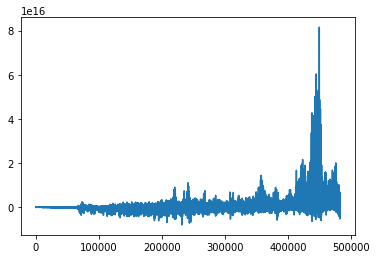

In [63]:
                    plt.plot((ddd[ddd>signal['missing_value']]))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


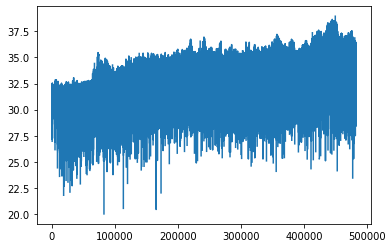

In [64]:
        plt.plot(np.log(ddd[ddd>signal['missing_value']]))

In [57]:
np.min(ddd[ddd>signal['missing_value']])

-6543130000000000.0

In [58]:
np.max(ddd[ddd>signal['missing_value']])


4.6955387e+16

In [77]:
df1 = pd.read_csv("/Users/rempicon/Google_Drive/MYCODE/PRJ/GIT/SpaceAppsCOVIDChallenge/data/OMNO2d_v2.csv")
df1.head()

,product_shortname,signal_name,value,year,month,day,hour,minutes,seconds
0,OMNO2,ColumnAmountNO2TropCloudScreened,2.733088e+14,2020,1,1,17,31,0
1,OMNO2,ColumnAmountNO2TropCloudScreened,3.099038e+14,2020,1,2,17,36,24
2,OMNO2,ColumnAmountNO2TropCloudScreened,3.069800e+14,2020,1,3,17,36,24
3,OMNO2,ColumnAmountNO2TropCloudScreened,3.066134e+14,2020,1,4,17,36,31
4,OMNO2,ColumnAmountNO2TropCloudScreened,2.445533e+14,2020,1,5,17,41,58


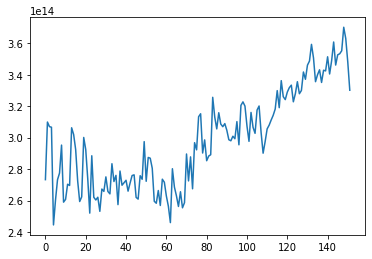

In [78]:

plt.plot(df1.value)

In [80]:
np.min(df1.value)

244553256796160.0

In [81]:
np.max(df1.value)

370121893740544.0

# Statistics 

In [307]:
print(f0[datainfo_OMAEROG['datafield']+"/CloudPressure"])
dd= f0[datainfo_OMAEROG['datafield']+"/CloudPressure"]

<HDF5 dataset "CloudPressure": shape (15, 720, 1440), type "<f4">


<HDF5 dataset "AerosolOpticalThicknessMWPrecision": shape (15, 720, 1440), type "<i2">


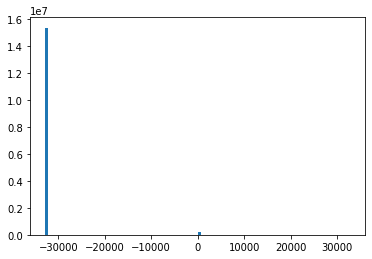

In [314]:
dd = np.array(dd)
ddd = dd.reshape([dd.shape[0]*dd.shape[1]*dd.shape[2]])
h = plt.hist(ddd, 100)

(array([2.07069e+05, 2.99300e+03, 9.94000e+02, 3.55000e+02, 1.94000e+02,
        1.03000e+02, 8.60000e+01, 9.40000e+01, 9.10000e+01, 6.10000e+01]),
 array([    0. ,  3275.1,  6550.2,  9825.3, 13100.4, 16375.5, 19650.6,
        22925.7, 26200.8, 29475.9, 32751. ]),
 <a list of 10 Patch objects>)

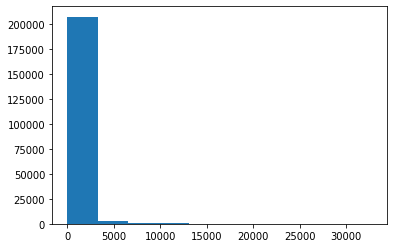

In [324]:
plt.hist(ddd[ddd>-32767])

In [319]:
np.max(ddd[ddd>-32767])

32751

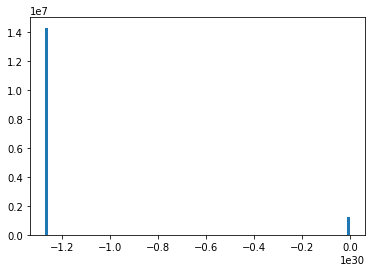

In [309]:
dd2 =  np.array(dd) 
ddd2 = dd2.reshape([dd2.shape[0]*dd2.shape[1]*dd2.shape[2]])
h = plt.hist(ddd2, 100)


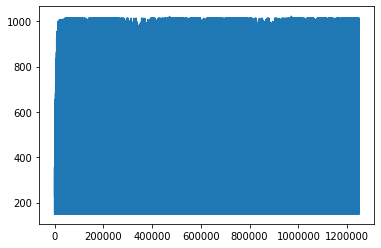

In [312]:
plt.plot(ddd2[ddd2>-1.2676506e+30])

In [294]:
np.exp(np.nanmean(np.log(ddd+1)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


461.36197

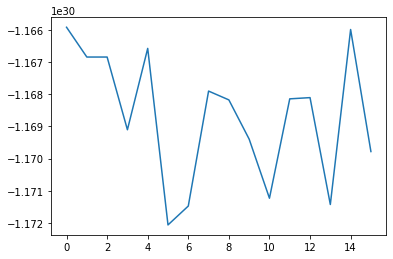

In [219]:
m_03 = get_stats(datainfo_OMAEROG, "/CloudPressure", datafiles_OMAEROG)
plt.plot(m_03)

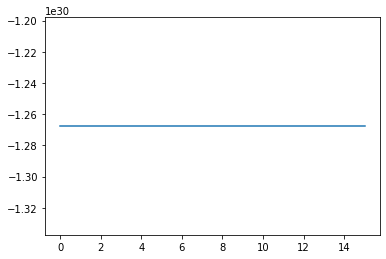

In [236]:
m_03 = get_stats(datainfo_OMAEROG, "/CloudPressure", datafiles_OMAEROG, index=12,stat=np.mean)
plt.plot(m_03)

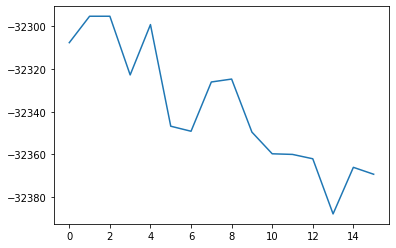

In [91]:
m_03 = get_stats(datainfo_OMAEROG, "/AerosolOpticalThicknessMW", datafiles_OMAEROG)
plt.plot(m_03)

In [86]:
dfn

'/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/ColumnAmountNO2TropCloudScreened'

<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION']>


ValueError: not enough values to unpack (expected 2, got 1)

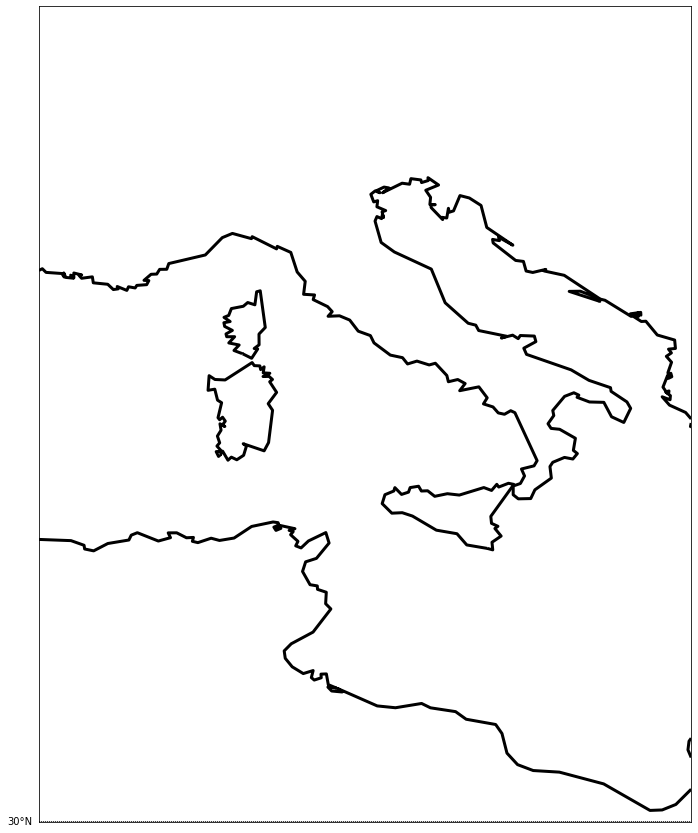

In [84]:
fn = os.path.join(datadescr['path'], datafiles[0])
dfn = datadescr['datafield']+"/ColumnAmountNO2TropCloudScreened"
loc = location_range_italy

show_map(fn, dfn, loc)





























# OMSO2

In [237]:
datainfo_omso2 = {"path":"./OMSO2", "datafield":"/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields/"}
datafiles_omso2 = get_files(dataloc_omso2['path'])

f0 = h5py.File(os.path.join(datainfo_omso2['path'], datafiles_omso2[0]),"r")
print(f0[datainfo_omso2['datafield']].keys())

<KeysViewHDF5 ['ColumnAmountO3', 'ColumnAmountSO2_PBL', 'Latitude', 'LineNumber', 'Longitude', 'OrbitNumber', 'PacificSectorAverage', 'RadiativeCloudFraction', 'RelativeAzimuthAngle', 'SceneNumber', 'SlantColumnAmountSO2', 'SolarZenithAngle', 'TerrainHeight', 'Time', 'ViewingZenithAngle']>


In [239]:
print(f0[datainfo_omso2['datafield']+"/SlantColumnAmountSO2"])
dd = f0[datainfo_omso2['datafield']+"/SlantColumnAmountSO2"]

<HDF5 dataset "SlantColumnAmountSO2": shape (720, 1440), type "<f4">


In [240]:
dd[0]

array([-1.2676506e+30, -1.2676506e+30, -1.2676506e+30, ...,
       -1.2676506e+30, -1.2676506e+30, -1.2676506e+30], dtype=float32)

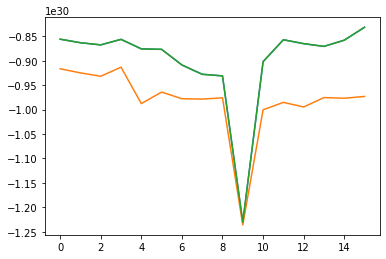

In [56]:



#location_range_italy = {"llcrnrlat":30, "urcrnrlat" : 50, "llcrnrlon":4, "urcrnrlon" : 20}
#location_range_all = {"llcrnrlat":-90, "urcrnrlat" : 90, "llcrnrlon":-180, "urcrnrlon" : 180}


m_03 = get_stats(datainfo_omso2, "/ColumnAmountO3", datafiles_omso2)
plt.plot(m_03)

m_so2pbl = get_stats(datainfo_omso2, "/ColumnAmountSO2_PBL", datafiles_omso2)
plt.plot(m_so2pbl)



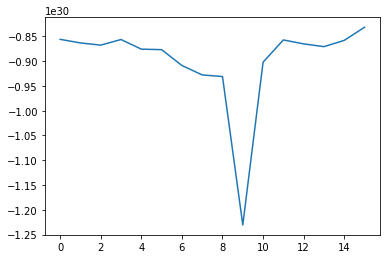

In [60]:
m_3 = get_stats(datainfo_omso2, "/RelativeAzimuthAngle", datafiles_omso2)
plt.plot(m_3)

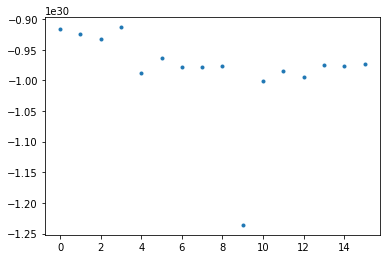

In [126]:
out = []
for f in data_files:
    out.append(get_stats(os.path.join(data_info['path'], f), data_info['datafield']+"/SlantColumnAmountSO2", location_range_all))
       

plt.plot(out,'.')

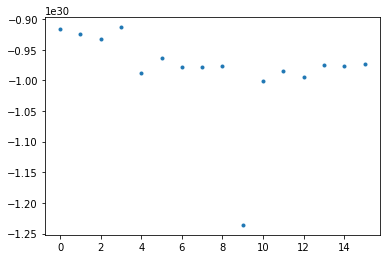

# info

Each file contains daily data from approximately 15 orbits

to dowload data
https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Download%20Data%20Files%20from%20HTTPS%20Service%20with%20wget


In [92]:
a.keys()
print(a['/HDFEOS/GRIDS/'].keys())
print(a['/HDFEOS/GRIDS/ColumnAmountAerosol/Data Fields/'].keys())

<KeysViewHDF5 ['OMI Total Column Amount SO2']>


KeyError: 'Unable to open object (component not found)'

In [57]:
#NO2
a.keys()
print(a['/HDFEOS/GRIDS/'].keys())
print(a['/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields/'].keys())

<KeysViewHDF5 ['OMI Total Column Amount SO2']>


KeyError: 'Unable to open object (component not found)'

In [61]:
#NO2
print(a.keys())
print(a['/HDFEOS/GRIDS'].keys())
print(a['/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields/'].keys())

<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION']>
<KeysViewHDF5 ['OMI Total Column Amount SO2']>
<KeysViewHDF5 ['ColumnAmountO3', 'ColumnAmountSO2_PBL', 'Latitude', 'LineNumber', 'Longitude', 'OrbitNumber', 'PacificSectorAverage', 'RadiativeCloudFraction', 'RelativeAzimuthAngle', 'SceneNumber', 'SlantColumnAmountSO2', 'SolarZenithAngle', 'TerrainHeight', 'Time', 'ViewingZenithAngle']>


In [62]:
d = a['/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields/ColumnAmountO3']
print(d.shape)


(720, 1440)


In [63]:
title

NameError: name 'title' is not defined

In [64]:
location_range_italy = {"llcrnrlat":30, "urcrnrlat" : 50, "llcrnrlon":4, "urcrnrlon" : 20}
location_range_all = {"llcrnrlat":-90, "urcrnrlat" : 90, "llcrnrlon":-180, "urcrnrlon" : 180}


In [65]:
FILE_NAME

NameError: name 'FILE_NAME' is not defined

<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION']>


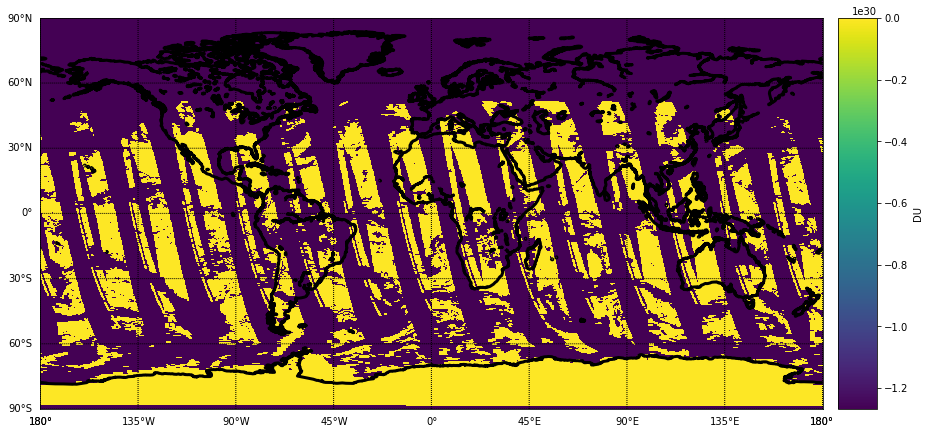

In [68]:

location_range_italy = {"llcrnrlat":30, "urcrnrlat" : 50, "llcrnrlon":4, "urcrnrlon" : 20}
location_range_all = {"llcrnrlat":-90, "urcrnrlat" : 90, "llcrnrlon":-180, "urcrnrlon" : 180}


# Open file.
FILE_NAME = os.path.join(datainfo_omso2['path'], datafiles_omso2[3])
DATAFIELD_NAME = datainfo_omso2['datafield']+"/ColumnAmountO3"
loc = location_range_all
fig = plt.figure(figsize=[15,15])
with h5py.File(FILE_NAME, mode='r') as f:
    # List available datasets.
    print(f.keys())

    # Read dataset.
    dset = f[DATAFIELD_NAME]
    data = dset[:]

    # Handle fill value.
    #data[data == dset.fillvalue] = np.nan
    #data = np.ma.masked_where(np.isnan(data), data)

    # Get attributes needed for the plot.
    # String attributes actually come in as the bytes type and should
    # be decoded to UTF-8 (python3).
    title = dset.attrs['Title'].decode()
    units = dset.attrs['Units'].decode()
    
    longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
    latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125
    
    #m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat = 90, llcrnrlon=-180, urcrnrlon = 180)
    m = Basemap(projection='cyl', 
                resolution='l', 
                llcrnrlat=loc["llcrnrlat"], 
                urcrnrlat = loc["urcrnrlat"], 
                llcrnrlon=loc["llcrnrlon"], 
                urcrnrlon = loc["urcrnrlon"])
    
    m.drawcoastlines(linewidth=3)
    m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])
    #x, y = m(longitude, latitude,)
    

    aaa = m.pcolormesh(longitude, latitude, data, latlon=True)
    cb = m.colorbar()
    cb.set_label(units)

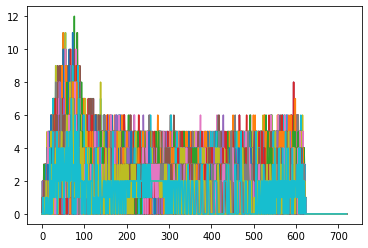

In [49]:
pl = plt.plot(data)

In [51]:
data[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [12]:
a['HDFEOS']

<HDF5 group "/HDFEOS" (2 members)>

In [4]:
with h5py.File('a.hdf', 'r') as f:  
    data = f['default'] 
    

OSError: Unable to open file (file signature not found)

In [1]:
# Set the URL string to point to a specific data URL. Some generic examples are:
   #   https://servername/data/path/file
   #   https://servername/opendap/path/file[.format[?subset]]
   #   https://servername/daac-bin/OTF/HTTP_services.cgi?KEYWORD=value[&KEYWORD=value]
URL = 'https://acdisc.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FAura_OMI_Level2G%2FOMAEROG.003%2F2019%2FOMI-Aura_L2G-OMAEROG_2019m1201_v003-2019m1202t062554.he5&FORMAT=aGU1Lw&BBOX=43.77%2C7.614%2C46.406%2C13.151&TIME=2019-12-01T08%3A00%3A00%2F2019-12-01T12%3A00%3A00&LABEL=OMI-Aura_L2G-OMAEROG_2019m1201_v003-2019m1202t062554.SUB.he5&FLAGS=GRIDTYPE__GRID&SHORTNAME=OMAEROG&SERVICE=SUBSET_LEVEL2&VERSION=1.02&DATASET_VERSION=003'
   
# Set the FILENAME string to the data file name, the LABEL keyword value, or any customized name. 
   
import requests
result = requests.get(URL)


In [2]:
result

<Response [401]>

In [ ]:
try:
    result.raise_for_status()
    f = open(FILENAME,'wb')
    f.write(result.content)
    f.close()
    print('contents of URL written to '+FILENAME)
except:
      print('requests.get() returned an error code '+str(result.status_code))

In [ ]:
import requests

# Fill in your details here to be posted to the login form.
payload = {
    'inUserName': 'username',
    'inUserPass': 'password'
}

# Use 'with' to ensure the session context is closed after use.
with requests.Session() as s:
    p = s.post('LOGIN_URL', data=payload)
    # print the html returned or something more intelligent to see if it's a successful login page.
    print p.text

    # An authorised request.
    r = s.get('A protected web page url')
    print r.text
        # etc...

In [40]:
import pyaudio
import numpy as np

p = pyaudio.PyAudio()

for volume in np.arange(1,2, 0.01):
    #volume = np.0.5     # range [0.0, 1.0]
    fs = 10100       # sampling rate, Hz, must be integer
    duration = 2.0   # in seconds, may be float
    f = 230.0        # sine frequency, Hz, may be float

    # generate samples, note conversion to float32 array
    samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)

    #samples = np.random.rand(100)
    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    # play. May repeat with different volume values (if done interactively) 
    stream.write(volume*samples)

stream.stop_stream()
stream.close()

p.terminate()

KeyboardInterrupt: 

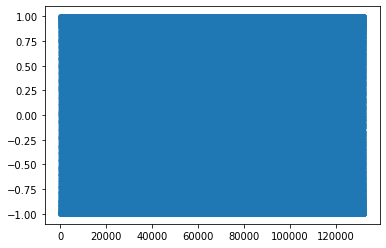

In [12]:
plt.plot(samples, ".")